In [1]:
import os
BASE_DIR = os.getcwd()
print(BASE_DIR)

C:\Users\ASUS\OneDrive\Desktop\handwritten-text-recognition-main


In [2]:
!pip install fpdf
!pip install tensorflow

## Importing libraries

In [3]:
import cv2
import json
import errno
from text_segmentation import words, page
from htr.utils import implt

import string
from htr.generator import Tokenizer, DataGenerator

from htr.network import puigcerver, ctc_loss, ctc_decode
from tensorflow.keras.models import Model

import numpy as np
from htr.preprocessing import preprocess, normalization, threshold

from tqdm.notebook import tqdm
from fpdf import FPDF


In [4]:
def draw_boxes(img, boxes):
    img = img.copy()
    for x1, y1, x2, y2 in boxes:
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 240), 1)
    return img

## Steps

### Load image

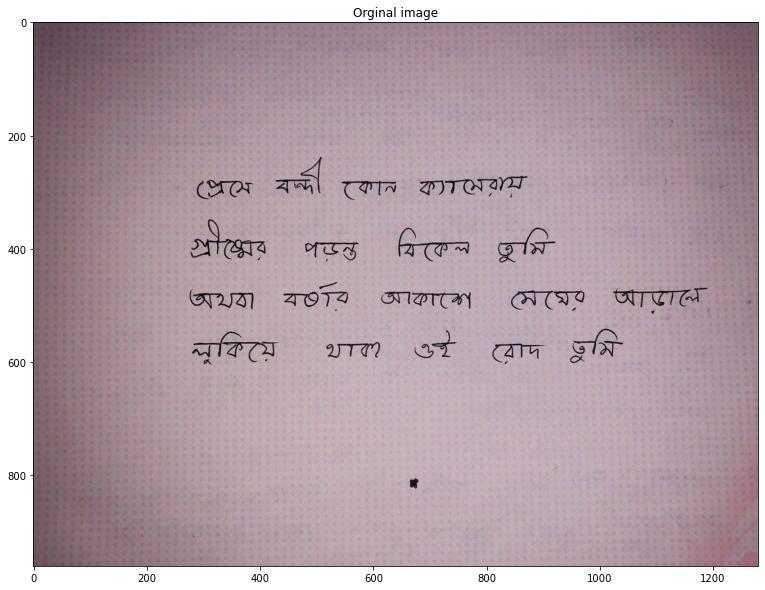

In [5]:
img = cv2.imread('images/ban-4.jpg')
implt(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), figsize=(20, 10), title='Orginal image')

### Page detection

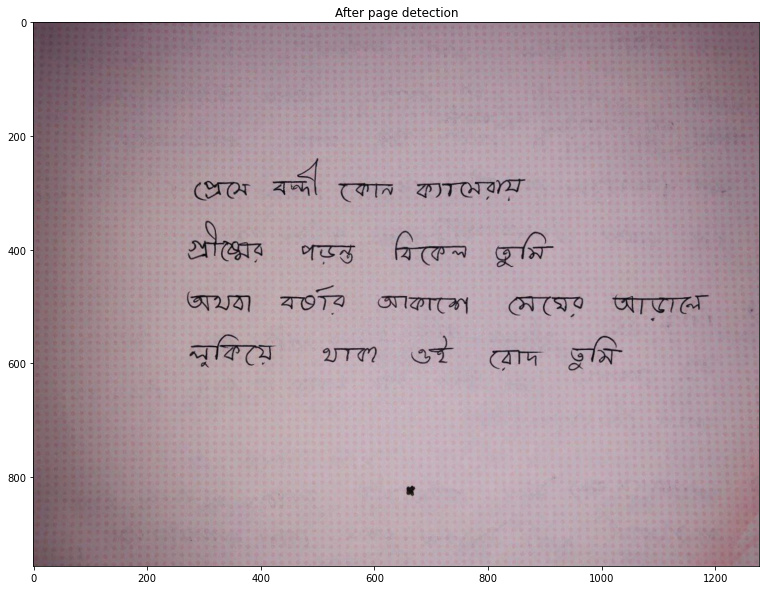

In [6]:
crop = page.detection(img)
implt(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB), figsize=(20, 10), title='After page detection')

### Word segmentation
Get bounding boxes for each words

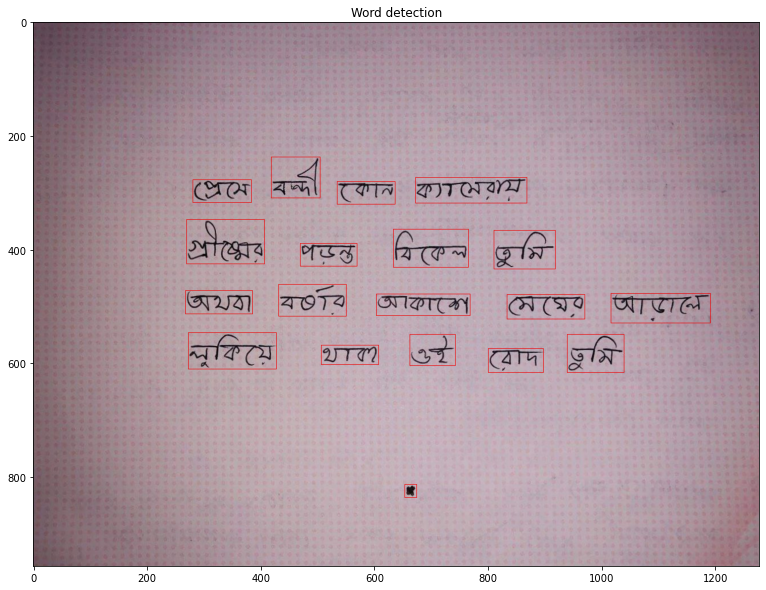

In [7]:
boxes = words.detection(crop)
implt(cv2.cvtColor(draw_boxes(crop, boxes), cv2.COLOR_BGR2RGB), figsize=(20, 10), title='Word detection')

### Get words from each line

In [8]:
lines = words.sort_words(boxes)

No. of lines: 5


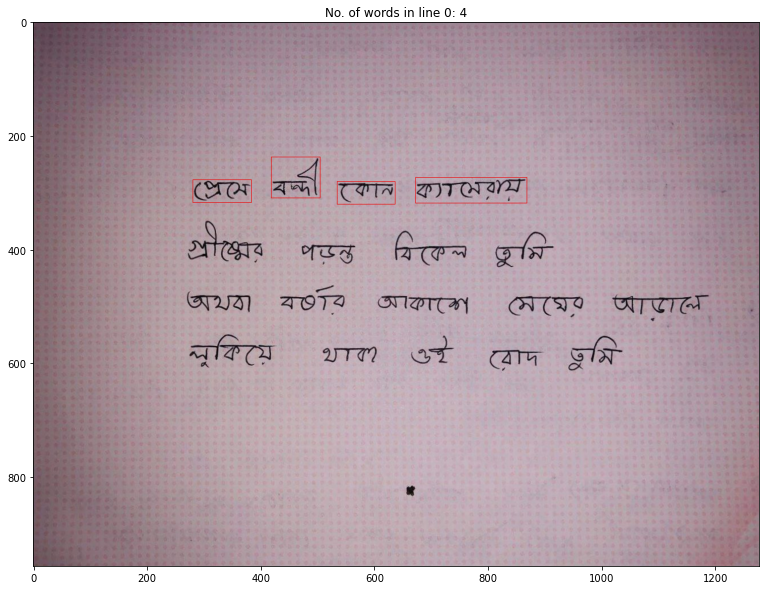

In [9]:
print('No. of lines:', len(lines))
n=0

implt(cv2.cvtColor(draw_boxes(crop, lines[n]), cv2.COLOR_BGR2RGB), 
      figsize=(20, 10), 
      title=f'No. of words in line {n}: {len(lines[n])}')

### Binarization 

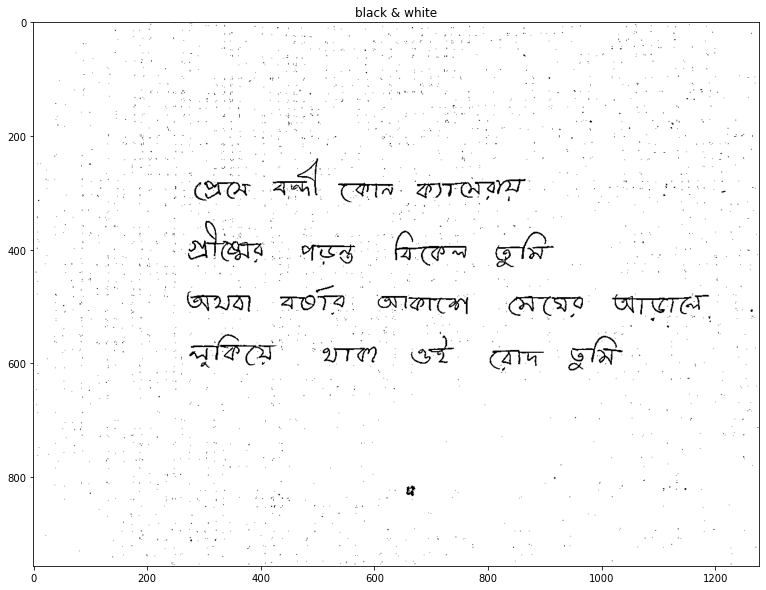

In [10]:
# crop.shape -> (H, W, C)
# crop_bw.shape -> (H, W)
crop_bw = threshold(crop, block_size=13)
implt(cv2.cvtColor(crop_bw, cv2.COLOR_GRAY2RGB), figsize=(20, 10), title='black & white')

### Set up parameters

In [11]:
# Parameters
input_size = (1024, 128, 1)
bangla_chars = json.load(open(os.path.join(BASE_DIR, 'htr', 'data', 'bangla-characters.json')))
charset = ''.join(bangla_chars) + string.punctuation + ' '
max_text_len = 128

# Filepaths
output_path = os.path.join(BASE_DIR, 'htr', 'data', 'output-bangla')
target_path = os.path.join(output_path, 'checkpoint_weights_bangla.hdf5')

### Tokenizer for tokenizing and decoding predicted text

In [12]:
tokenizer = Tokenizer(charset=charset, max_text_len=max_text_len)

### Load pre-trained model

In [13]:
# Model
inputs, outputs = puigcerver(input_size=input_size, d_model=tokenizer.vocab_size + 1)
model = Model(inputs=inputs, outputs=outputs)

# Load weights from target_path
if os.path.isfile(target_path):
    model.load_weights(target_path)
    print('===== Pre-trained weights loaded =====')
else:
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), target_path)

===== Pre-trained weights loaded =====


### Predict
Get prediction of each image of each lines from the model, decode the predicted text.

In [14]:
output = ''
for line in tqdm(lines):
    imgs = []
    for x1, y1, x2, y2 in line:
        word = crop_bw[y1:y2, x1:x2]
        imgs.append(preprocess(img=word, input_size=input_size))
    
    X = normalization(imgs)
    Y_pred = model.predict(X)
    predictions, probabilities = ctc_decode(Y_pred)
    y = [tokenizer.decode(y) for y in predictions]
    output += ' '.join(y) + '\n'
#a variable pdf
#pdf = FPDF()
#add a page 
#pdf.add_page()
#save syle and size of font in the pdf
#pdf.set_font("Kalpurush", 15)
#pdf.write(4 ,output)
#pdf.output("answer2.pdf")
print(output)

1/1 [==============================] - 0s 150ms/step

প্রেমে বন্দী কোন ক্যাসেরায়
গ্রীশ্মের পড়ন্ত বিকেল তুমি
অথবা রত্তর আকাশে মেঘের আড়ালে
লুকিয়ে থাকা এই রোদ তুমি
*

